# Animating Sea Ice Concentration in the Artic (NSIDC)

#### Requirements:
- Python (Anaconda recommended)
- IDE / Text editor that can handle Jupyter Notebooks
- Packages:
    - pandas
    - matplotlib
    - cartopy
    - numpy
    - xarray
    - tqdm
    - seaborn

- System:
    - Tested on Windows but should work on Linux, too
#### Other:
More data can be found from https://nsidc.org/data. Login is required for some datasets.

In [16]:
from ftplib import FTP
import os
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cartopy.feature as cf
import matplotlib.colors
import xarray as xr
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from tqdm.notebook import tqdm
import datetime as dt

In [21]:
#source : https://nsidc.org/support/64231694-FTP-Client-Data-Access

# NSIDC
# Sample script to download all the files within one directory on the FTP server

### The following 3 variables can be changed ###
# 1. Set the directory you would like to download the files to
# (now destdir is current directory on Windows)
destdir= os.getcwd()
#this is sometimes needed, since the format needs to be "path\\to\\location"
if not "\\\\" in destdir:
    destdir = destdir.replace("\\","\\\\")
print("Destination of the files " + destdir)
# 2. Set the path to the FTP directory that contains the data you wish to download.
# This example is for Gridded Monthly Sea Ice Extent and Concentration
# https://nsidc.org/data/g10010
# go to the site, click "Download Data" -> "Go to FPT" and you should see
# the adress "ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G10010_V2/"
directory = '/DATASETS/NOAA/G10010_V2/'
# 3. Set the password which will be your email address
# (this seems to often be unnececcary)
password = 'email_address'

############################################
### Don't need to change this code below ###
############################################
# FTP server
ftpdir = 'sidads.colorado.edu'
#Connect and log in to the FTP
print('Logging in')
ftp = FTP(ftpdir)
ftp.login('USER','PASS')

# Change to the directory where the files are on the FTP
print('Changing to '+ directory)
ftp.cwd(directory)

# Get a list of the files in the FTP directory
files = ftp.nlst()
files = files[2:]
# If this prints directories (i.e. no file format), en error occurs. The directories can be manually removed 
# or if they contain someting important, you can change the directory to e.g. /DATASETS/NOAA/G10010_V2/shapefiles/
print(files)
#Change to the destination directory on own computer where you want to save the files
os.chdir(destdir)

#Download all the files within the FTP directory
for file in files:
    print('Downloading...' + file)
    ftp.retrbinary('RETR ' + file, open(file, 'wb').write)

#Close the FTP connection
ftp.quit()

In [247]:
#path to the downloaded file
file = destdir+"\\G10010_SIBT1850_V2.zip"

In [250]:
with ZipFile(file, 'r') as zipObj:
   #extract all the contents of zip file in current directory
   zipObj.extractall()

In [35]:
#NetCDF file
file = destdir+"\\G10010_SIBT1850_v2.0.nc"
ds = xr.open_dataset(file)

In [36]:
#date format
ds["time"] = ds["time"].astype("datetime64[ns]")
#take mean of each year
ds = ds.groupby(ds.time.dt.year).mean(keep_attrs=True)
#change land's value to NaN (so that it doesn't mess up the colorbar)
ds = ds.where(ds != 120.0, np.nan)

In [37]:
#create a colormap from Seaborn palette 
cmap = sns.color_palette("light:b", as_cmap=True).reversed()

  0%|          | 0/168 [00:00<?, ?it/s]

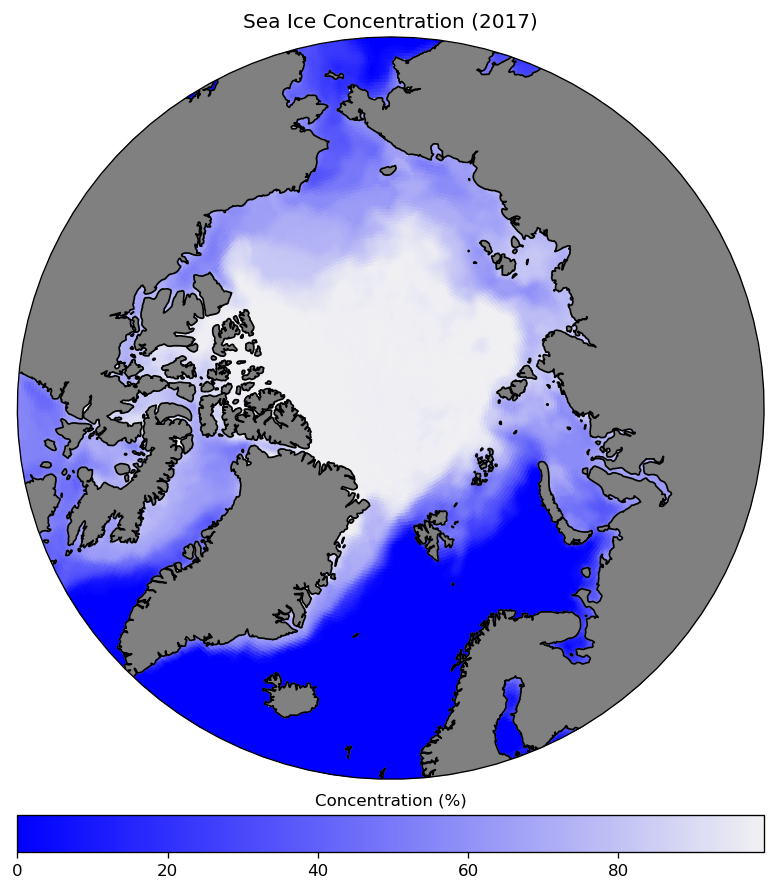

In [38]:
#progress bar
with tqdm(total=len(ds.seaice_conc), colour="green") as pbar:
    #set figure, facecolor helps to keep text nice
    fig = plt.figure(facecolor="white", figsize=(16, 9), dpi=1920/16)
    #set axes, preferred projection
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    #global axes, coastlines to map
    ax.set_global()
    ax.coastlines()
    #first frame
    data = ds.seaice_conc.isel(year=0)
    cs = ax.pcolormesh(ds.longitude, ds.latitude, data, transform=ccrs.PlateCarree(),animated=True, cmap=cmap)
    #locatable axis -> easier to fit colorbar
    divider = make_axes_locatable(ax)
    #define axis for the colorbar
    ax_cb = divider.new_vertical(size="5%", pad=0.3, axes_class=plt.Axes, pack_start=True)
    #add new axis
    fig.add_axes(ax_cb)
    #add colorbar
    cb = fig.colorbar(cs, cax=ax_cb, orientation="horizontal")
    #title for colorbar
    cb.ax.set_title('Concentration (%)',fontsize=10)
    #title for plot
    title = ax.set_title(f"Sea Ice Concentration ({ds.year[0].values})")
    #extent of the plot
    ax.set_extent((0,360,60,90),crs=ccrs.PlateCarree())
    #make area circular
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5,0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    #color land gray and make it the uppermost layer
    ax.add_feature(cf.LAND, facecolor="gray", zorder=1)

    #animation loop
    def animate(i):
        #new values for colormesh
        cs.set_array(ds.seaice_conc.isel(year=i).values.ravel())
        title.set_text(f"Sea Ice Concentration ({ds.year[i].values})")
        pbar.update(1)
        return cs,title,

    #create animation. Each month has own frame, interval between frames 200 ms
    anim = animation.FuncAnimation(fig, animate, frames=len(ds.seaice_conc), repeat=False, init_func=None, interval=200, blit=True)
    #save animation (since Jupyter Notebook can't show it)
    anim.save('Sea_Ice.mp4', writer=animation.FFMpegWriter())

In [39]:
#add 2 more colours to colormap
cm = plt.get_cmap('tab20b')
cm_list = list(cm.colors)
cm_list.append((0.9,0.71,1))
cm_list.append((1,0.79,1))
cmap = matplotlib.colors.ListedColormap(cm_list)

Text(0.5, 1.0, 'Regions of the Arctic')

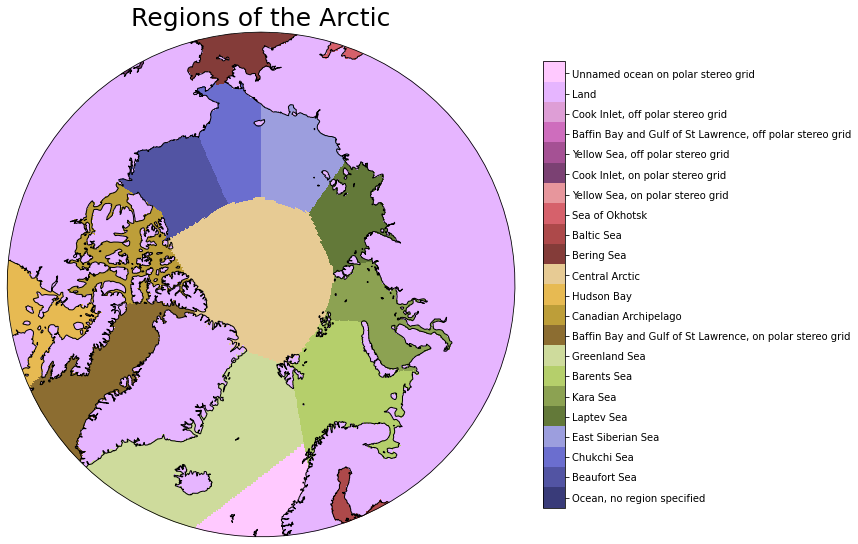

In [40]:
#create figure
fig = plt.figure(figsize=(10,20))
#set axis, preferred projection
axs = plt.axes(projection=ccrs.NorthPolarStereo())
#data for the plot
data = ds.LandRegion_mask
cs = axs.pcolormesh(ds.longitude, ds.latitude, data.isel(year=-1), transform=ccrs.PlateCarree(), cmap=cmap)
#extent of the plot
axs.set_extent((0,360,60,90),crs=ccrs.PlateCarree())
#make area circular
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5,0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axs.set_boundary(circle, transform=axs.transAxes)
#coastlines
axs.coastlines()
#colorbar for each area
cbar = fig.colorbar(cs, ax=axs, fraction=0.04, ticks=[(i+0.5)*0.95 for i in range(0,22)])
#rename areas
cbar.set_ticklabels(list(data.attrs.values())[4:])
#set title for the plot
axs.set_title("Regions of the Arctic", size=25)